# playing Atari with Deep Learning

In [1]:
# choose game
game = "Pong-v0"

# generate Dataset by random play

* saving only good sequences

In [2]:
import numpy as np
import gym

env = gym.make(game)
x_data = [] # Bilder (States)
y_data = [] # Label (Aktionen)

DATASET_SIZE = 20
saved_episodes = 0

# Datensatz generieren
the_end = False
while not the_end:
    done = False
    state = env.reset()
    episode_obs = []
    episode_acts = []
  
    while not done:
        action = env.action_space.sample()
        episode_obs.append(state)
        episode_acts.append(action)
        state, reward, done, info = env.step(action)
    
        if reward < 0:
            episode_acts = []
            episode_obs = []
        elif reward > 0:
            x_data += episode_obs
            y_data += episode_acts
            episode_obs = []
            episode_acts = []
            saved_episodes += 1
            if saved_episodes % 10 == 0:
                print(saved_episodes)
            if saved_episodes+1 > DATASET_SIZE:
                print("Dataset completed")
                the_end = True

10
20
Dataset completed


# Preprocessing

In [3]:
x_data = np.array(x_data)
y_data = np.array(y_data)
x_data.shape, y_data.shape

((1476, 210, 160, 3), (1476,))

In [4]:
x_data[0].shape

(210, 160, 3)

### resize images to 84x84 pixels

In [7]:
import cv2
def resize(img):
    height = 84
    width = 84
    return cv2.resize(img, (width, height), interpolation=cv2.INTER_AREA)

In [9]:
resized_x_data = [resize(img) for img in x_data]
resized_x_data = np.array(resized_x_data)

Text(0.5, 1.0, 'Resized')

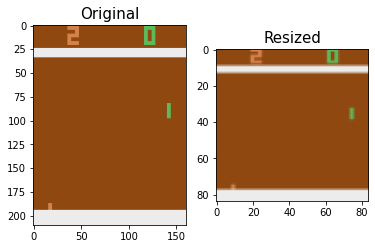

In [10]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,2)

axs[0].imshow(x_data[0, :, :, :])
axs[0].set_title("Original", fontsize="15")
axs[1].imshow(resized_x_data[0, :, :, :])
axs[1].set_title("Resized", fontsize="15")

### RGB to Grayscale

In [11]:
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = np.reshape(img, (img.shape[0], img.shape[1], 1))
    return img

In [12]:
gray_x_data = [grayscale(img) for img in resized_x_data]
gray_x_data = np.array(gray_x_data)

Text(0.5, 1.0, 'Grayscale')

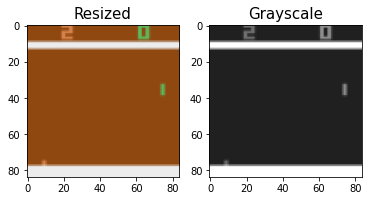

In [13]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(resized_x_data[0, :, :, :])
axs[0].set_title("Resized", fontsize="15")
axs[1].imshow(gray_x_data[0, :, :, 0], cmap="gray")
axs[1].set_title("Grayscale", fontsize="15")

### Frame Stack

In [14]:
from collections import deque
def framestack(dataset):
    data = []
    frames = deque(maxlen=4)

    # initialize first deque
    for _ in range(4):
        frames.append(dataset[0])
    framestack = np.asarray(frames, dtype=np.float32)
    framestack = np.moveaxis(framestack, 0, -1).reshape(84, 84, -1)

    # create deques from dataset
    for state in dataset:
        frames.append(state)
        framestack = np.asarray(frames, dtype=np.float32)
        framestack = np.moveaxis(framestack, 0, -1).reshape(84, 84, -1)
        data.append(framestack)

    return data

In [15]:
stack_data = framestack(gray_x_data) 
stack_data = np.array(stack_data)

(1476, 84, 84, 4)

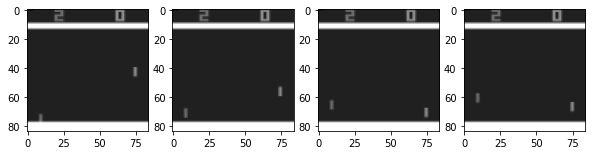

In [16]:
fig, axs = plt.subplots(1, 4, figsize=(10,5))
axs[0].imshow(stack_data[0+4, :, :, 0], cmap="gray") # +4, because of 4 same initial frames
axs[1].imshow(stack_data[1+4, :, :, 1], cmap="gray")
axs[2].imshow(stack_data[2+4, :, :, 2], cmap="gray")
axs[3].imshow(stack_data[3+4, :, :, 3], cmap="gray")

### converting labels to categorical labels

In [18]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y=y_data, num_classes=env.action_space.n)

### shuffle data

In [20]:
# create random indices
idx = np.random.permutation(len(x_data))
# x - resized grayscale input
# x_stacked - resized grayscale input in framestacks
# labels - actions in to_categorical
x, x_stacked, labels = gray_x_data[idx], stack_data[idx], y[idx]

# create a model


In [37]:
import tensorflow
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam

def create_nn(input_shape, output_shape):
    net_input = Input(shape=input_shape)
    x = Conv2D(filters=32, kernel_size=(8, 8), strides=(4, 4), padding="same")(net_input)
    x = Activation("relu")(x)
    x = Conv2D(filters=64, kernel_size=(4, 4), strides=(2, 2), padding="same")(x)
    x = Activation("relu")(x)
    x = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="same")(x)
    x = Activation("relu")(x)
    x = Flatten()(x)
    x = Dense(512)(x)
    x = Activation("relu")(x)
    x = Dense(output_shape)(x)
    net_output = Activation("softmax")(x)

    OPTIMIZER = Adam(lr=0.0005)

    model = Model(inputs=net_input, outputs=net_output)
    model.compile(loss="categorical_crossentropy", optimizer=OPTIMIZER, metrics=["categorical_accuracy"])

    return model

# Train a model on resized-grayscale input



In [23]:
x.shape[1:]

(84, 84, 1)

In [29]:
labels.shape[1]

6

In [38]:
model_1 = create_nn(x.shape[1:], labels.shape[1])

In [40]:
EPOCHS = 30

result_1 = model_1.fit(
    x,
    labels,
    batch_size=32,
    epochs=EPOCHS, 
    verbose=1)

Epoch 1/30
47/47 [==============================] - 4s 94ms/step - loss: 1.7943 - categorical_accuracy: 0.1870
Epoch 2/30
47/47 [==============================] - 4s 94ms/step - loss: 1.7886 - categorical_accuracy: 0.1863
Epoch 3/30
47/47 [==============================] - 4s 94ms/step - loss: 1.7912 - categorical_accuracy: 0.1633
Epoch 4/30
47/47 [==============================] - 4s 93ms/step - loss: 1.7904 - categorical_accuracy: 0.1850
Epoch 5/30
47/47 [==============================] - 4s 93ms/step - loss: 1.7893 - categorical_accuracy: 0.1890
Epoch 6/30
47/47 [==============================] - 4s 93ms/step - loss: 1.7924 - categorical_accuracy: 0.1843
Epoch 7/30
47/47 [==============================] - 4s 93ms/step - loss: 1.7885 - categorical_accuracy: 0.1795
Epoch 8/30
47/47 [==============================] - 4s 93ms/step - loss: 1.7848 - categorical_accuracy: 0.1958
Epoch 9/30
47/47 [==============================] - 4s 93ms/step - loss: 1.7915 - categorical_accuracy: 0.1992
E

KeyboardInterrupt: ignored

# Train a model on resized-grayscale-framestack input



In [41]:
x_stacked.shape[1:]

(84, 84, 4)

In [42]:
labels.shape[1]

6

In [46]:
model_2 = create_nn(x_stacked.shape[1:], labels.shape[1])

In [48]:
EPOCHS = 30

result_2 = model_2.fit(
    x_stacked,
    labels,
    batch_size=32,
    epochs=EPOCHS, 
    verbose=1)

Epoch 1/30
25/47 [==============>...............] - ETA: 2s - loss: 1.7838 - categorical_accuracy: 0.1912

KeyboardInterrupt: ignored